In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.PINN.train_PINN import *
from matplotlib.tri import Triangulation
%load_ext autoreload
%autoreload 2

Using device: cuda


In [ ]:
data = dataset_Sobol(12, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**12+4)

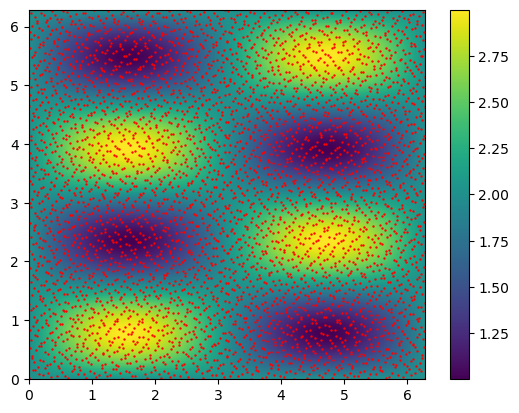

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
H1 = torch.tensor([1, 0], device=dev).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
def a_function(x,y):
    a = 2+np.sin(x)*np.sin(2*y)
    return a
def A(x):
    a = (2+torch.sin(x[:,0])*torch.sin(2*x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [4]:
net_H1 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H1_{total_params}'}

Number of parameters: 1801


In [ ]:
net_H1 = load_network(net_H1, args['name']+'', args)
net_H1 = net_H1.to(dev)

In [9]:
losses_train, losses_val = train(net_H1, loaders, args, A, H1)

Epoch: 0 mean train loss:  3.89235098e-01, mean val. rec. loss:  3.55799109e-01
Epoch: 1 mean train loss:  3.55692490e-01, mean val. rec. loss:  3.30813522e-01
Epoch: 2 mean train loss:  3.30713685e-01, mean val. rec. loss:  3.10362753e-01
Epoch: 3 mean train loss:  3.10234835e-01, mean val. rec. loss:  2.93337773e-01
Epoch: 4 mean train loss:  2.93192660e-01, mean val. rec. loss:  2.79011439e-01
Epoch: 5 mean train loss:  2.78847957e-01, mean val. rec. loss:  2.66807964e-01
Epoch: 6 mean train loss:  2.66637349e-01, mean val. rec. loss:  2.56253019e-01
Epoch: 7 mean train loss:  2.56054773e-01, mean val. rec. loss:  2.46962086e-01
Epoch: 8 mean train loss:  2.46765973e-01, mean val. rec. loss:  2.38625072e-01
Epoch: 9 mean train loss:  2.38417176e-01, mean val. rec. loss:  2.31004785e-01
Epoch: 10 mean train loss:  2.30793586e-01, mean val. rec. loss:  2.23918284e-01
Epoch: 11 mean train loss:  2.23698987e-01, mean val. rec. loss:  2.17227641e-01
Epoch: 12 mean train loss:  2.17005715

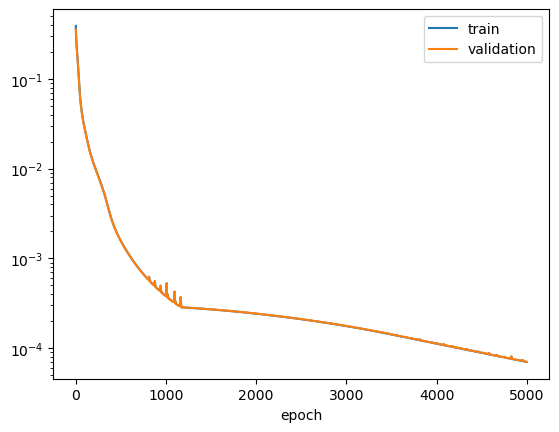

In [10]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [13]:
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : 'NN_library/PINN/PINN_H2'}
net_H2 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H2.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1801


In [14]:
net_H2 = load_network(net_H2, args['name']+'_4999', args)
net_H2 = net_H2.to(dev)

In [12]:
losses_train, losses_val = train(net_H2, loaders, args, A, H2)

Epoch: 0 mean train loss:  1.04646527e+00, mean val. rec. loss:  1.02990171e+00
Epoch: 1 mean train loss:  1.02904868e+00, mean val. rec. loss:  1.01658676e+00
Epoch: 2 mean train loss:  1.01571630e+00, mean val. rec. loss:  1.00507042e+00
Epoch: 3 mean train loss:  1.00422458e+00, mean val. rec. loss:  9.94678547e-01
Epoch: 4 mean train loss:  9.93833803e-01, mean val. rec. loss:  9.85029332e-01
Epoch: 5 mean train loss:  9.84166008e-01, mean val. rec. loss:  9.75875727e-01
Epoch: 6 mean train loss:  9.75007401e-01, mean val. rec. loss:  9.67052845e-01
Epoch: 7 mean train loss:  9.66191810e-01, mean val. rec. loss:  9.58454654e-01
Epoch: 8 mean train loss:  9.57583112e-01, mean val. rec. loss:  9.50024327e-01
Epoch: 9 mean train loss:  9.49165717e-01, mean val. rec. loss:  9.41725288e-01
Epoch: 10 mean train loss:  9.40841478e-01, mean val. rec. loss:  9.33535400e-01
Epoch: 11 mean train loss:  9.32671020e-01, mean val. rec. loss:  9.25424837e-01
Epoch: 12 mean train loss:  9.24549725

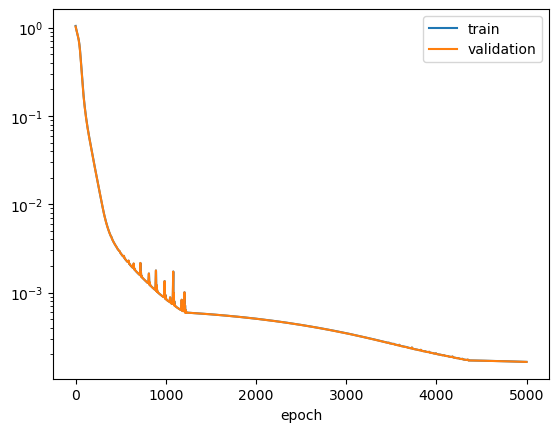

In [15]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [16]:
U1 = net_H1(grid_data).detach().cpu()
U2 = net_H2(grid_data).detach().cpu()

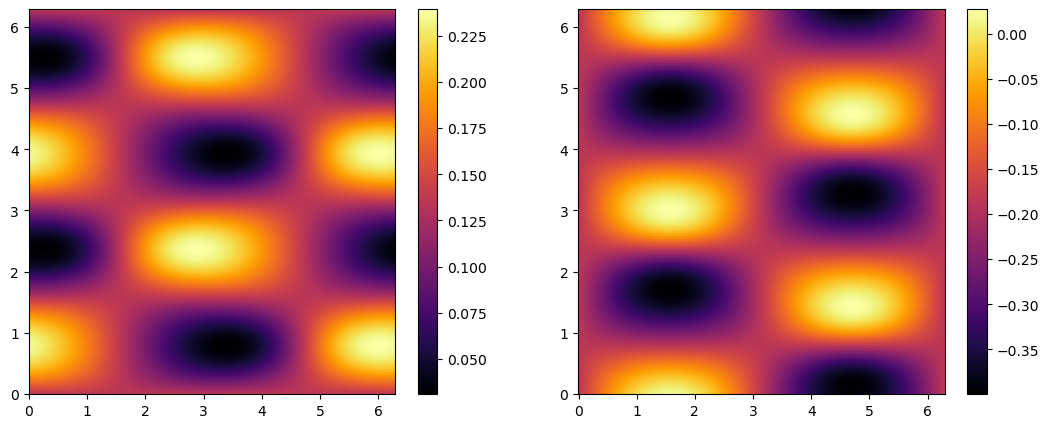

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

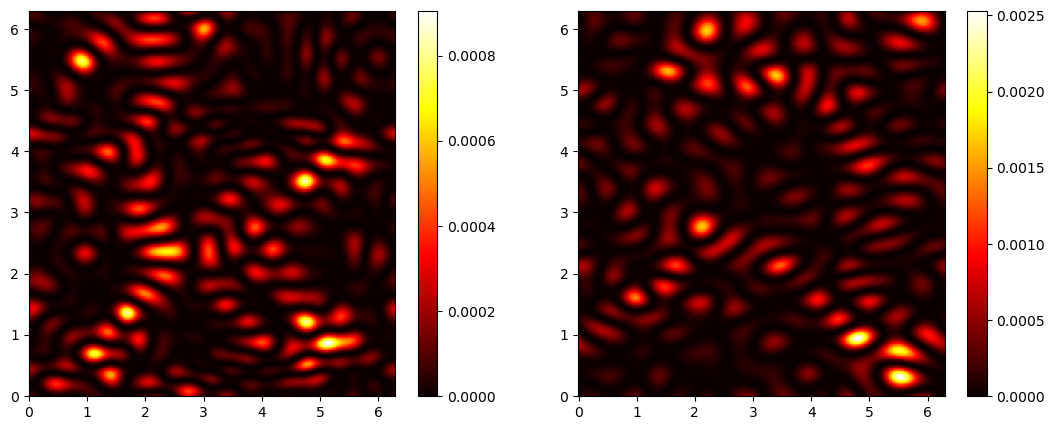

In [27]:
error_1 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()
error_2 = PDE_loss(grid_data, net_H2, A, H2).detach().cpu()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='hot')
#axs[0].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N), cmap='hot')
#axs[1].scatter(data[:,0], data[:,1], s=0.5, c='g')
fig.colorbar(pos2, ax=axs[1])

In [28]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
T2 = net_H2(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1),
            create_graph=True, retain_graph=True
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2),
            create_graph=True, retain_graph=True
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [29]:
def compute_bound(dq1, dq2, tri, data):
    # Compute the A_h
    A_h = np.zeros((2,2))
    n_elem = len(tri.triangles)
    for i in range(n_elem):
        elem = tri.triangles[i]
        node_coords = data[elem]
        vector = node_coords[1:]-node_coords[:-1]
        vectors = torch.hstack((vector, torch.tensor([[0], [0]], device=dev)))
        area = (1/2) * abs(torch.cross(vectors[0], vectors[1])[-1])
        A_loc = A(node_coords)
        Q1 = A_loc @ (dq1[elem] + H1).view(3,2,1)
        Q2 = A_loc @ (dq2[elem] + H2).view(3,2,1)
        Q1_mean = Q1.mean(dim=0)
        Q2_mean = Q2.mean(dim=0)
        A_h_elem_1 = (area * Q1_mean).squeeze().detach().cpu().numpy()
        A_h_elem_2 = (area * Q2_mean).squeeze().detach().cpu().numpy()
        A_h[:,0] += A_h_elem_1
        A_h[:,1] += A_h_elem_2
    return A_h / L**2

In [30]:
A_bound = compute_bound(dq1, dq2, triang, inputs)
print(A_bound)

[[ 1.97443841e+00 -9.66203444e-05]
 [-1.06178342e-04  1.89555959e+00]]


In [31]:
np.save(f'bounds/A_u_NN_{total_params}.npy', A_bound)